In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [7]:
all_image_path=glob.glob('2_class/*/*.jpg')

In [3]:
all_image_path[:5]#切片操作只要前五章

['2_class\\airplane\\airplane_001.jpg',
 '2_class\\airplane\\airplane_002.jpg',
 '2_class\\airplane\\airplane_003.jpg',
 '2_class\\airplane\\airplane_004.jpg',
 '2_class\\airplane\\airplane_005.jpg']

In [4]:
all_image_path[-5:]#切片操作只要倒数后五张

['2_class\\lake\\lake_696.jpg',
 '2_class\\lake\\lake_697.jpg',
 '2_class\\lake\\lake_698.jpg',
 '2_class\\lake\\lake_699.jpg',
 '2_class\\lake\\lake_700.jpg']

In [5]:
import random #为了让模型不知学习一个类型（因为在处理中，前面所有的类型在一起）
#所以我们要对整个数据集进行乱序
random.shuffle(all_image_path)
all_image_path[:5]

['2_class\\airplane\\airplane_110.jpg',
 '2_class\\airplane\\airplane_608.jpg',
 '2_class\\airplane\\airplane_596.jpg',
 '2_class\\airplane\\airplane_536.jpg',
 '2_class\\lake\\lake_546.jpg']

In [6]:
#我们在这样的分类问题上，我们需要将标签与数据相对应
label_to_index={'airplane' : 0,'lake': 1}



In [7]:
index_to_label=dict((v,k) for k,v in label_to_index.items())
index_to_label
#这样我们就完成了对于刚才列表的简单翻转

{0: 'airplane', 1: 'lake'}

In [8]:
img=all_image_path[101]#我们通过阅览要提取它的类别，需要去看中间的那个值
img

'2_class\\lake\\lake_121.jpg'

In [9]:
label=img.split('\\')[1]#通过观察我们发现，lake在分割后的第二个，所以我们这样去提取
label

'lake'

In [10]:
print(label_to_index.get(label))#获取标签对应的编码

1


In [11]:
all_labels=[label_to_index.get(img.split('\\')[1]) for img in all_image_path]

In [12]:
all_labels[:5]#这样我们就得到了所有图片对应的标签

[0, 0, 0, 0, 1]

In [13]:
#接下来我们要做的方法就是如何读取图片
img_1 =tf.io.read_file(all_image_path[1])
#但这样读取之后是个二进制的形式，我们需要去对该二进制解码


In [14]:
img_1=tf.image.decode_jpeg(img_1)#对产生的二进制文件进行解码

In [15]:
print(img_1.shape)#这样我们就看到了该图片的数据为256*256*3
img_1.dtype#uint8的数值范围是0到255,代表了每张图片的解码

(256, 256, 3)


tf.uint8

In [16]:
#然而对于深度模型学习，使用浮点数效果较好，所以我们最好需要将数据类型转换
img_1=tf.cast(img_1,tf.float32)
img_1.dtype

tf.float32

In [17]:
#之后，我们对他进行归一化
img_1=img_1/255
#这样我们就完成了对于图片的读取
#由下面的步骤组成，读取为二进制文件，解码，转化类型，归一化


In [33]:
#加载图片
def load_img(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)#限定维度为3
    #如果输入图片大小需要修改，那么我们在解码后进行resize
    img=tf.image.resize(img,[256,256])
    #增加规范性的管道可以让tf.data知道图片的规范
    img=tf.cast(img,tf.float32)
    img=img/255
    return img

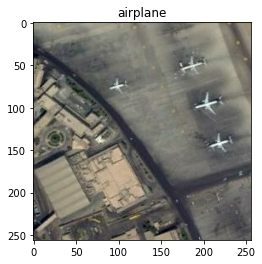

In [25]:
i=random.choice(range(len(all_image_path)))
img=all_image_path[i]
label=all_labels[i]
img_1=load_img(img)
plt.title(index_to_label.get(label))
plt.imshow(img_1.numpy())#plt显示的是ndarry类型，所以我们需要类型转换
#随机选取一张图片并显示,并显示它的标签

In [34]:
img_ds=tf.data.Dataset.from_tensor_slices(all_image_path)

In [35]:
#对于地址的tensor，我们利用load_img函数将所有地址转化为图片
img_ds=img_ds.map(load_img)

In [36]:

img_ds

<MapDataset shapes: (256, 256, 3), types: tf.float32>

In [38]:
label_ds=tf.data.Dataset.from_tensor_slices(all_labels)
label_ds
#制作标签的数据集

<TensorSliceDataset shapes: (), types: tf.int32>

In [43]:
for la in label_ds.take(10):
    print(la.numpy())

0
0
0
0
1
1
1
0
0
0


In [44]:
#整个数据的压制就完成了，接下来为了完成任务，我们还需要划分测试与训练集
data=tf.data.Dataset.zip((img_ds,label_ds))
data

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [46]:
data_nums=len(all_image_path)
test_nums=int(data_nums*0.2)
train_nums=data_nums-test_nums
train_nums
#分割数据集

1120

In [48]:
train_ds=data.skip(test_nums)#跳过测试集的图片其他都为训练集
test_ds=data.take(test_nums)

In [49]:
batch_size=16
train_ds=train_ds.repeat().shuffle(train_nums).batch(16)
#防止电脑缓存超标，我们设置shuffle的参数要尽量小，batch_size也要尽量选择
#batch方法只能运行一次，每次运行维度增加一份none

In [50]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [51]:
test_ds=test_ds.batch(batch_size)

In [53]:
#绝大部分的中间层激活函数为relu
#每层卷积后的图像仍然为四维图像
#batch hight width channel
from keras import layers
model=keras.Sequential()
model.add(layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(512,(3,3),activation='relu'))
model.add(layers.Conv2D(512,(3,3),activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))#二分类问题使用我们输出单个的值
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 59, 59, 256)      

In [57]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.Accuracy())


In [58]:
steps=train_nums//batch_size
steps_valid=test_nums//batch_size
history=model.fit(train_ds,epochs=1,steps_per_epoch=steps,validation_data=test_ds,validation_steps=steps_valid)


70/70 [==============================] - 675s 10s/step - loss: 0.6394 - accuracy: 0.0000e+00 - val_loss: 0.2277 - val_accuracy: 0.0000e+00


In [2]:
import tensorflow as tf
from tensorflow import keras
model=tf.keras.models.load_model('CNN.h5')

In [3]:
def load_img(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[256,256])
    img=tf.cast(img,tf.float32)
    img=img/255.0
    return img
    

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [12]:
import glob
index_to_label={0: 'airplane', 1: 'lake'}
all_image_path=glob.glob('2_class/*/*.jpg')
def pred_img(path):
    img=load_img(path)
    img=tf.expand_dims(img,axis=0)
    res=model.predict(img)
    print(index_to_label.get((res>0.5).astype('int')[0][0]))

In [13]:
print(all_image_path[0])

2_class\airplane\airplane_001.jpg


airplane


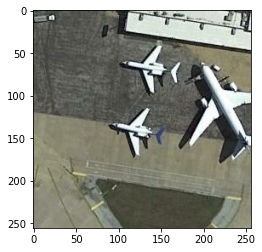

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
i=random.choice(range(len(all_image_path)))
img=load_img(all_image_path[i])
plt.imshow(img.numpy())
pred_img(all_image_path[i])

In [1]:
import cv2
path='C:\\Users\\admin\\Desktop\\suanfa'
img=cv2.imread(path)

In [2]:
img.shape

(1080, 1920, 3)

In [6]:
img_720p=cv2.resize(img,(720,1280), interpolation=cv2.INTER_NEAREST)
img_720p.shape


(1280, 720, 3)

In [10]:
label_to_size={'360p':(360,480),'720p':(480,360),'480p':(480,640)}
pred=label_to_size.get('360p')
print(pred)

(360, 480)


In [33]:
# 360p    (480×360，20帧/秒) ，4：3，录制一分钟大约7MB；
# 480p    (640×480，20帧/秒)，4：3，录制一分钟大约12MB；
# 720p    (1280×720，30帧/秒)  ， 16:9，录制一分钟大约35MB；
def resize_image(src,dst,param):
    label_to_size={'360p':(360,480),'720p':(720,1280),'480p':(480,640)}
    size=label_to_size.get(param)
    if size==None:
        print('Your param is wrong!Please enter the right params')
        return 0
    
    # dst=cv2.resize(src,size, interpolation=cv2.INTER_NEAREST)
    dst=cv2.resize(src,size)
    return dst
print(resize_image(img,dst,'720p').shape)
print(resize_image(img,dst,'480p').shape)
print(resize_image(img,dst,'360p').shape)

(1280, 720, 3)
(640, 480, 3)
(480, 360, 3)


In [26]:
import os


In [35]:
path='C:\\Users\\admin\\Desktop\\suanfa'
img2=resize_image(img,dst,'720p')
all_image_path=os.path.join(path,'11.png')
print(all_image_path)
cv2.imwrite(all_image_path,img2)


C:\Users\admin\Desktop\suanfa\11.png


True